# Load file
D:\github\2H_TaSe2_Tc_STM\getPhasemap.ipynb

In [1]:
import pickle
with open('pa.pkl','rb') as f:
    pa = pickle.load(f)

In [2]:
from imagingPhase import visPhase as vp
from matplotlib import pyplot as plt

imagingPhase package loaded


In [6]:
import importlib
importlib.reload(vp)

<module 'imagingPhase.visPhase' from 'd:\\github\\2H_TaSe2_Tc_STM\\imagingPhase\\visPhase.py'>

In [7]:
idt = 0
tmp = vp.phiPrinter(pa[0][idt])

phase uploaded
phase calculated


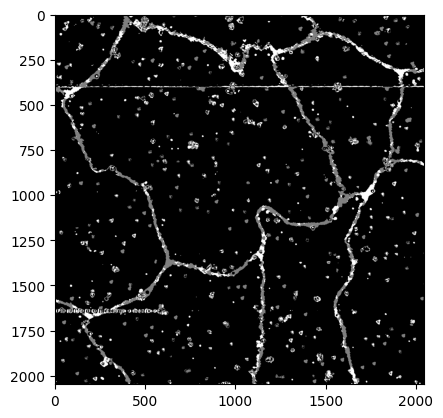

In [8]:
tmp.pHAC()

In [ ]:

Phi1 = pa[0][idt][0]
Phi2 = -pa[0][idt][1]
angle_restores_g = pa[0][idt]


In [25]:
Info2 = vectorized_phaseInfo(Phi1, Phi2)

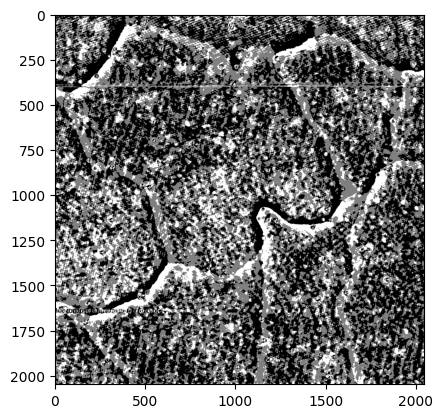

In [42]:
plt.imshow(Info2[3][:,:,0],cmap='gray')

In [26]:
Info2[0].shape

(2048, 2048, 4)

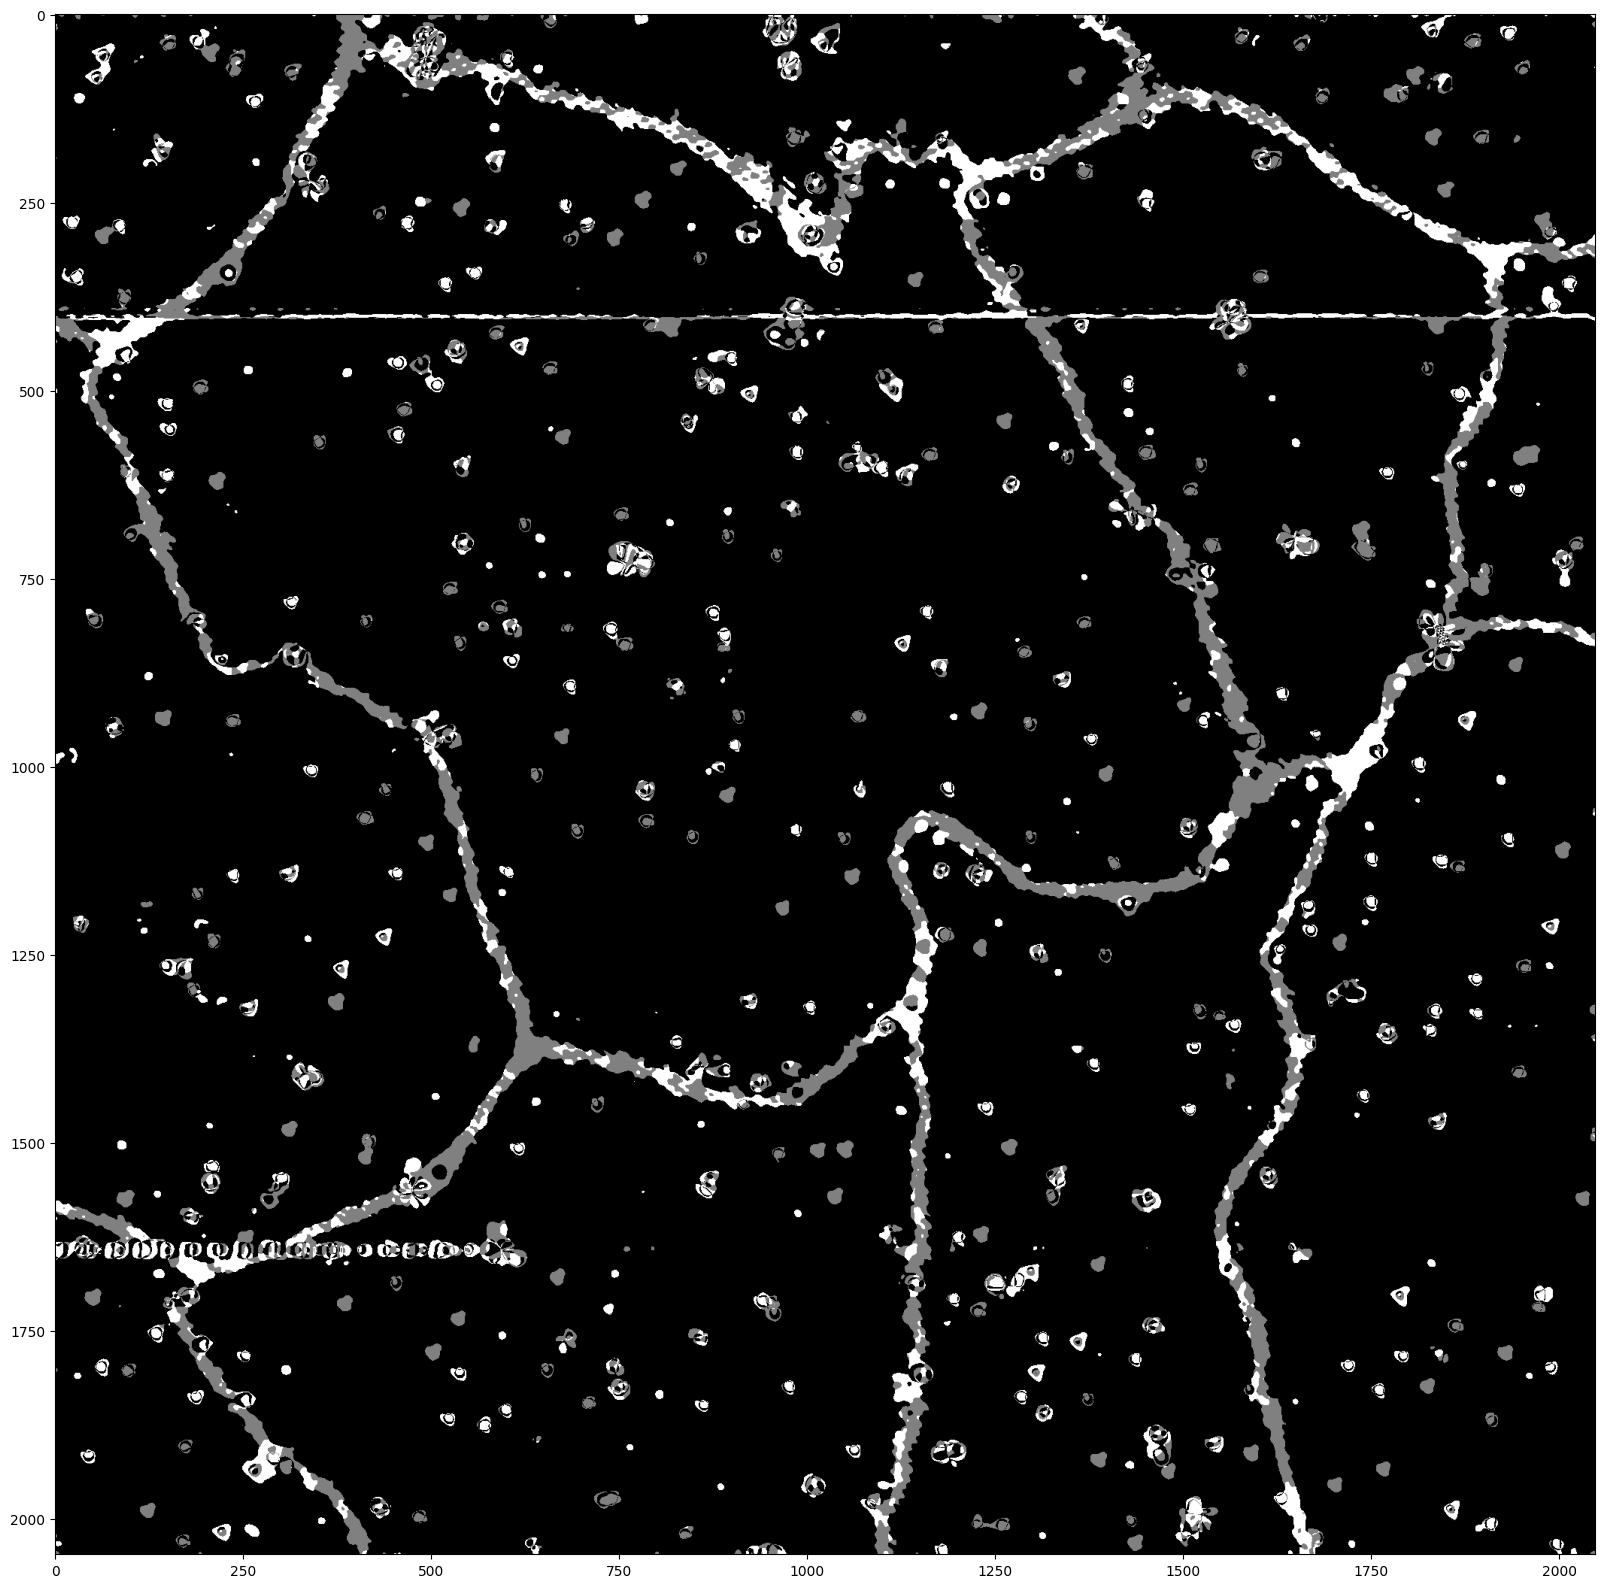

In [16]:
HAC_holder = Info2[1]
HAC_argmax = np.argmax(HAC_holder, axis=2)
fig = plt.figure(figsize=(20,20))
plt.imshow(HAC_argmax,cmap='gray')

In [17]:
HAC_holder[0].shape

(2048, 3)

In [18]:
def get_z3z3hex(Info):
  HHH_argmax = np.argmax(Info[0], axis=2)
  mod01,mod10 = np.divmod(HHH_argmax ,2)
  hex1 = np.mod(Info[2][:,:,0] + mod10,3)
  hex2 = np.mod(Info[2][:,:,1] + mod01,3)
  z3z3hex = np.stack((hex1,hex2),axis=2)
  return z3z3hex

In [19]:
z3z3hex = get_z3z3hex(Info2)

In [20]:
colors = {
    "Red Bright": (1.0, 0.302, 0.302),   # #FF4D4D
    "Red Dark":   (0.478, 0.110, 0.110), # #7A1C1C
    "Green Bright": (0.302, 1.0, 0.302), # #4DFF4D
    "Green Dark":   (0.110, 0.478, 0.110), # #1C7A1C
    "Blue Bright":  (0.302, 0.58, 1.0),  # #4D94FF
    "Blue Dark":    (0.110, 0.110, 0.478) # #1C1C7A
}

In [21]:
p_00 = [.5,.5,.5]
p_12 = [.1,.1,.1]
p_21 = [.8,.8,.8]

p_10 = colors["Red Dark"]
p_01 = colors["Green Dark"]
p_22 = colors["Blue Dark"]

p_20 = colors["Red Bright"]
p_02 = colors["Green Bright"]
p_11 = colors["Blue Bright"]

In [22]:
clrset = [[p_00,p_01,p_02],[p_10,p_11,p_12],[p_20,p_21,p_22]]
clrset = np.array(clrset)
clrset.shape

(3, 3, 3)

In [23]:
shp = z3z3hex.shape
phase9 = np.zeros((shp[0],shp[1],3))
for ix  in range(shp[0]):
  for iy in range(shp[1]):
    phase9[ix,iy,:] = clrset[int(z3z3hex[ix,iy,0]),int(z3z3hex[ix,iy,1]),:]

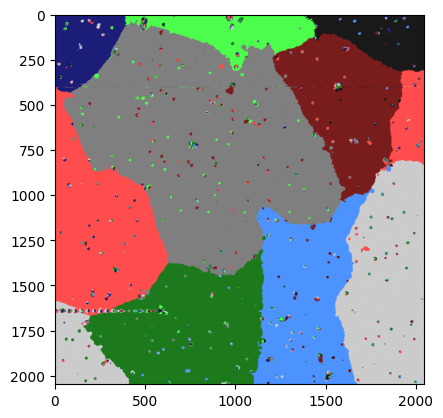

In [24]:
plt.imshow(phase9)

In [47]:
def getDWsegment(z6,is_close10):
  class6 = [210,201,120,102,21,12]
  blk = [1012,1102,120,210]
  rlk = [1120,1210,12,102]
  glk = [1021,1201,21,201]
  class12 = np.array([blk,rlk,glk])

  class6this = np.sum(z6*np.array([100,10,1]))
  z6 =  class6 == class6this
  class12this = class6this +1000*is_close10
  classified = class12 == class12this
  true_indices = np.where(classified)
  classified3 = true_indices[0][0]
  return classified3

In [49]:
Info = Info2

In [50]:
Z6 = Info[3]
Is_close10 = Info[0][:,:,2]>0

# ix,iy= 93,22

classified3s = np.zeros(Z6.shape[0:2])
for ix in range(Z6.shape[0]):
  for iy in range(Z6.shape[1]):
    z6 = Z6[ix,iy,:]# input 1
    is_close10 = Is_close10[ix,iy]# input 2
    classified3 = getDWsegment(z6,is_close10)
    classified3s[ix,iy] = classified3

In [51]:
classified3s_rgb = np.stack((classified3s==1,classified3s==0,classified3s==2),axis=2)

In [53]:
DWThick = .2
dlt = DWThick

In [54]:
dwBW = Info[1][:,:,0]<DWThick

In [55]:
dw_rgb = classified3s_rgb * dwBW[:, :, np.newaxis]

In [61]:
# Z3z3,Rphi12 =  z3z3split_vec(Phi1,Phi2)
Z3z3,Rphi12 = vp.z3z3split(Phi1,Phi2)
coefs = np.array([[-2/4,4/4],[1/2,1/2],[4/4,-2/4]])
# coefs.shape

In [62]:
chiral = np.einsum('ijk,li->jkl', np.array(Rphi12), coefs)
chiral = chiral[:,:,[2,0,1]]
chiral[:,:,2] = -chiral[:,:,2]

In [63]:
chiral_ = np.mod(chiral+dlt/2,.5)-dlt/2
chiral_ = -(1/dlt)*(chiral_-dlt/2)

In [64]:
final = chiral_*dw_rgb

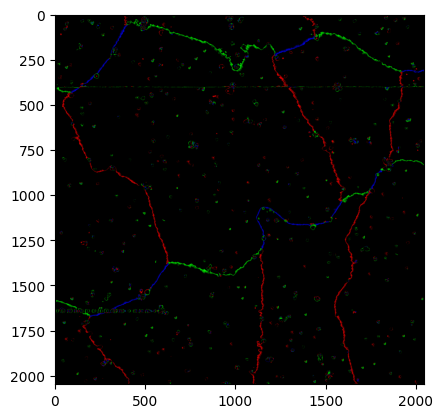

In [68]:
plt.imshow(final)

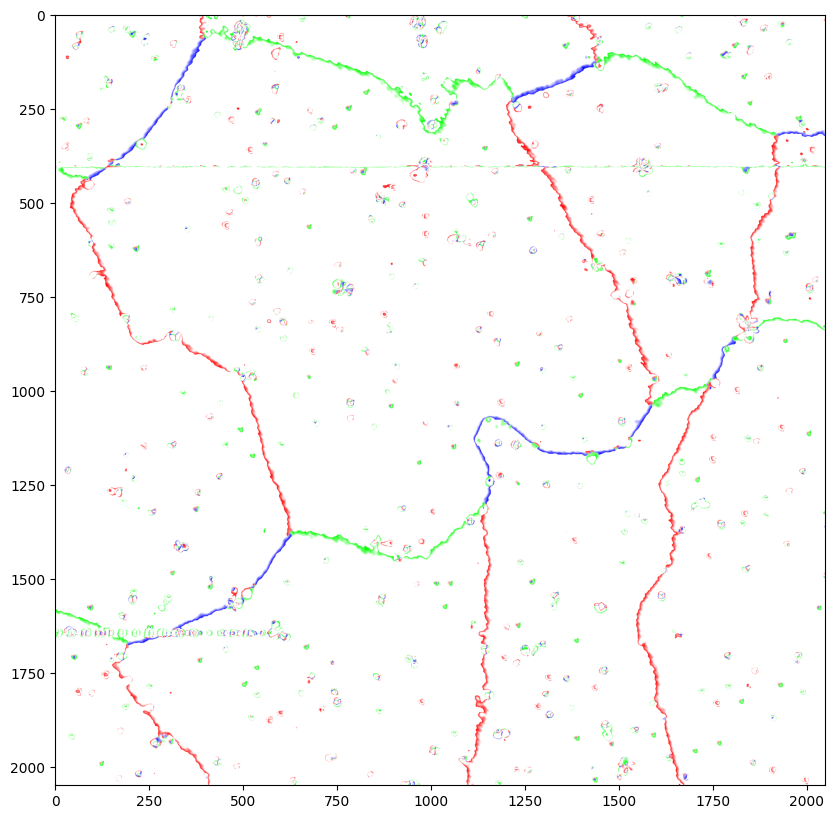

In [69]:
from skimage.color import rgb2hsv,hsv2rgb
final2 = rgb2hsv(final)
final2[:,:,1] = final2[:,:,2]
final2[:,:,2] = 1
final2 = hsv2rgb(final2)
fig = plt.figure(figsize=(10, 10))
plt.imshow(final2.astype(np.float64))

In [65]:
import numpy as np

def z3z3split_vec(phi1, phi2):
    phi1 = phi1 % (2*np.pi)
    phi2 = phi2 % (2*np.pi)
    phi1i = phi1 / (2*np.pi)
    phi2i = phi2 / (2*np.pi)
    z3z31, rphi1 = np.divmod(phi1i, 1/3)
    z3z32, rphi2 = np.divmod(phi2i, 1/3)
    z3z3 = np.stack([z3z31, z3z32], axis=-1)
    rphi12 = np.stack([rphi1*3, rphi2*3], axis=-1)
    return z3z3, rphi12

def rlsplit_vec(rphi12):
    is_close_10 = rphi12[...,0] > rphi12[...,1]
    # swap if not close
    rphi12_swapped = np.where(is_close_10[...,None], rphi12, rphi12[...,::-1])
    rphi12_C = np.stack([rphi12_swapped[...,0]-rphi12_swapped[...,1],
                         rphi12_swapped[...,1]], axis=-1)
    v_c1 = rphi12_C[...,0]
    v_c2 = rphi12_C[...,1]
    baryHHH_foo = np.stack([1-v_c1-v_c2, v_c1, v_c2], axis=-1)
    return is_close_10, baryHHH_foo

def sixsplit_vec(baryHHH_foo):
    z6 = np.argsort(baryHHH_foo, axis=-1)[...,::-1]
    p_BarHHH = np.take_along_axis(baryHHH_foo, z6, axis=-1)
    p_AffHHH = p_BarHHH[...,1:]
    I = np.array([[1,2],[1,-1]])
    p_AffHAC = np.einsum('ij,...j->...i', I, p_AffHHH)
    p_BarHAC = np.stack([1-p_AffHAC[...,0]-p_AffHAC[...,1],
                         p_AffHAC[...,0], p_AffHAC[...,1]], axis=-1)
    return z6, p_BarHAC

def get_baryHHH_vec(baryHHH_foo, is_close_10):
    out = np.zeros(baryHHH_foo.shape[:-1] + (4,))
    out[...,0] = baryHHH_foo[...,0]
    out[...,3] = baryHHH_foo[...,2]
    idx = (~is_close_10).astype(int)+1
    out[np.arange(out.shape[0])[:,None], np.arange(out.shape[1])[None,:], idx] = baryHHH_foo[...,1]
    return out

def get_baryHAC_vec(is_close_10, baryHAC_foo):
    baryHAC = baryHAC_foo.copy()
    swap_idx = np.array([0,2,1])
    baryHAC_swapped = baryHAC[...,swap_idx]
    return np.where(is_close_10[...,None], baryHAC, baryHAC_swapped)

def phaseInfo2_vec(Phi1, Phi2):
    z3z3, rphi12 = z3z3split_vec(Phi1, Phi2)
    is_close_10, baryHHH_foo = rlsplit_vec(rphi12)
    z6, baryHAC_foo = sixsplit_vec(baryHHH_foo)
    baryHHH = get_baryHHH_vec(baryHHH_foo, is_close_10)
    baryHAC = get_baryHAC_vec(is_close_10, baryHAC_foo)
    return baryHHH, baryHAC, z3z3, z6
